In [4]:
from Torchlurk import Lurk
import torchvision.models as models
from torchvision import transforms
%load_ext autoreload
%autoreload 2
from misc_funcs import clean_bw_imgs,sample_imagenet,plot_hist

In [7]:
from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import ToTensor,ToPILImage
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image
from collections import OrderedDict


import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from copy import deepcopy
from pathlib import Path

from ImageFolderWithPaths import ImageFolderWithPaths
from Projector import Projector

#libraries
sys.path.insert(1, '../lib/pytorch-cnn-visualizations/src/')
from cnn_layer_visualization import CNNLayerVisualization
from layer_activation_with_guided_backprop import GuidedBackprop
from misc_functions import save_gradient_images
from misc_funcs import create_folders

At that stage, Download the tinyimagenet dataset on [this link](https://www.kaggle.com/ifigotin/imagenetmini-1000#n01440764_10470.JPEG) and place it in the directory data (s.t the path looks like `data/tinyimagenet/rest_of_path`

Once the dataset is downloaded, we need to get rid of a few bw images: 

In [123]:
clean_bw_imgs("../data/imagenet-mini/train/")

Progression:0.00%


AssertionError: 

You might want to work on a subset of tinyimagenet for computations reason.

In [ ]:
sample_imagenet("../data/tinyimagenet/train/","../data/exsmallimagenet")

In [5]:
model = models.vgg16(pretrained=True)
# same preprocess used as vgg16
preprocess = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
    ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Run this cell if you want to create the information for the first time.

In [59]:
#watch out: once you chose a folder name for the computed images and a json name, the json name will point to that folder name exclusively.
lurker = Lurk(model,preprocess,save_comp_img_path='../results/06_05_20/'
                              ,save_json_pathname='../saved_model/06_05_20.json'
                              ,img_path="../data/50classes/")

If you wish to load a precomputed json, just add the `load_path` attribute. Watch out, it needs to be coherent with the folder name.

In [58]:
lurker = Lurk(model,preprocess,save_comp_img_path='../results/03_04_20/'
                              ,save_json_pathname='../saved_model/06_05_20.json',
                               load_path = '../saved_model/03_04_20.json')

Loading done!


In [9]:
lurker.compute_avgmax_imgs()
lurker.compute_filter_actmax(layer_indx = 0,filter_indxes=[2,3])
lurker.compute_filter_actmax(layer_indx=2,filter_indxes=[3,4])
lurker.compute_grads()

# Torchlurk

In [116]:
#watch out: once you chose a folder name for the computed images and a json name, the json name will point to that folder name exclusively.
lurker = Lurk(model,preprocess,save_comp_img_path='../results/06_05_20/'
                              ,save_json_pathname='../saved_model/06_05_20.json'
                              ,img_path="../data/50classes/")

## Current cursor

In [118]:
lurker.compute_avgmax_imgs()

saving done!


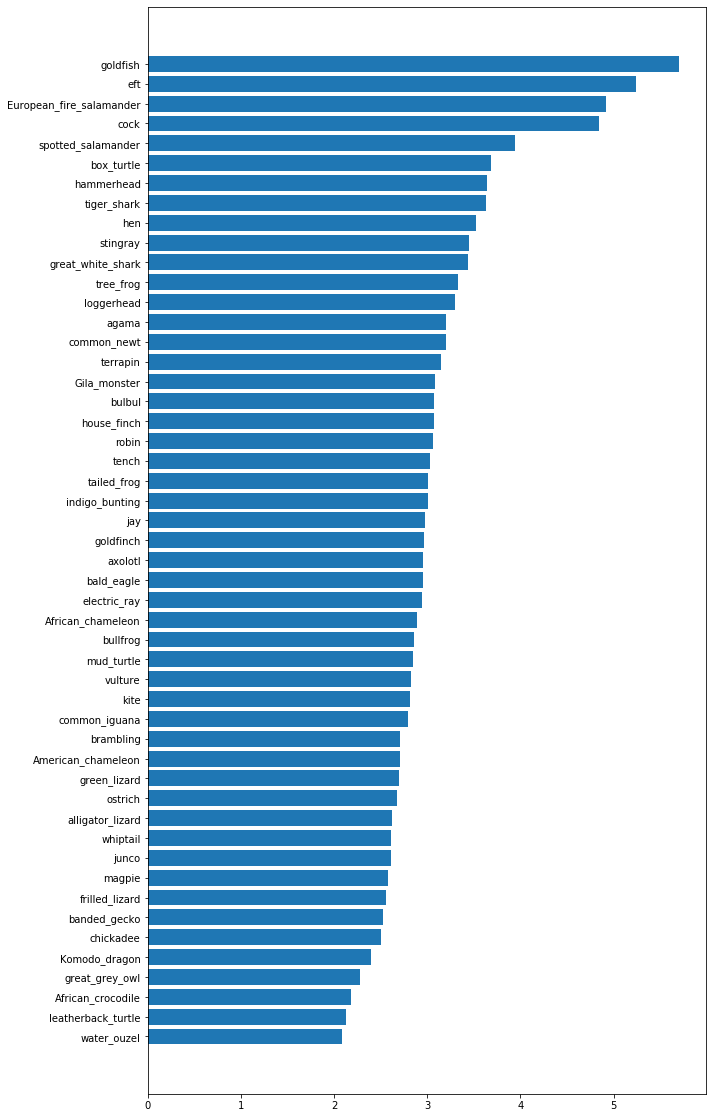

In [122]:
plot_hist(lurker.model_info[0]['filters'][0]['histo_counts_max'])

In [115]:
class Lurk():
    def __init__(self,model,preprocess,save_comp_img_path,save_json_pathname,load_path=None,img_path = "../data/exsmallimagenet/"):
        self.model = model
        self.preprocess = preprocess
        # allow to run reduced computations
        self.SINGLE_LAYER = True
        #number of layers we compute shit for
        self.N_LAYERS = 0
        #number of filters we compute images for
        self.N_REDUCE = 22
        #path to the numb image
        self.NUMB_PATH = "../data/tinyimagenet/numb.png"
        # how many top pictures we keep
        self.TOP_AVG_SIGN = 4
        #number of favourites images per filter
        self.N_FAV = 4
        # number of max spikes images per filter
        self.N_FAV_MAX = 3
        #where to save/load the saved models
        self.ORIGIN_PATH = save_comp_img_path
        #where to access the data
        self.DATA_PATH = "../data/"
        #where to access the tinyimagenet dataset
        self.TINY_PATH = os.path.join(self.DATA_PATH,"tinyimagenet/")
        #which folder to get the data from
        #self.IMGS_PATH = os.path.join(self.DATA_PATH,"exsmallimagenet")
        self.IMGS_PATH = img_path

        #where to save the json
        self.SAVE_PATHNAME_JSON = save_json_pathname
        
        self.my_dataset = ImageFolderWithPaths(self.IMGS_PATH,transform=self.preprocess)
        self.CLASS2INDX = self.my_dataset.class_to_idx
        
        labels_infos = self.recreate_labels(self.my_dataset,"../data/labels50.txt")
        self.INDX2TITLE = labels_infos.set_index('label')['title'].to_dict()
        assert(set(self.INDX2TITLE.keys())==(set(self.CLASS2INDX.values())))
        assert(len(self.INDX2TITLE) == len(self.CLASS2INDX))
        if load_path is not None:
            self.model_info = self.load_from_json(load_path)
        else:
            self.model_info = self.build_model()
        create_folders(self.ORIGIN_PATH,["avg_grads","max_grads","cropped","cropped_grad","max_activ"],self.model_info)
        
        
        self.data_loader = torch.utils.data.DataLoader(self.my_dataset, batch_size=1, shuffle=True)
        self.title_counts = dict(zip(self.INDX2TITLE.values(),[0] *len(self.INDX2TITLE)))
        #initiate the number of counts for 
        self.init_class_counts(self.INDX2TITLE, self.IMGS_PATH,self.title_counts)
        
    @staticmethod
    def recreate_labels(dataset,output_path):
        """
        recreate the label files wrt to a specific dataset with potentially less classes than the original one. 
        Useful for smaller computations
        """
        infos = pd.read_csv("../data/labels.txt",sep=" ",header=None)
        infos.columns = ['file_name','label','title']
        infos.set_index('file_name',inplace=True,drop=False)
        new_infos= infos.loc[dataset.class_to_idx.keys()].copy()
        new_infos.label = new_infos.file_name.map(dataset.class_to_idx)
        new_infos.to_csv(output_path,header=None,sep=" ")
        return new_infos
    def init_class_counts(self,indx_to_title,src_path,obj):
        """
        create the dictionary which counts the number of images per classes in the dataset
        """
        for subfold in os.listdir(src_path):
            subfold_path = os.path.join(src_path,subfold)
            count = len([name for name in os.listdir(subfold_path)])
            title = indx_to_title[self.CLASS2INDX[subfold]]
            obj[title] += count
        
    def save_to_json(self):
        model_info2 = deepcopy(self.model_info)
        for lay_info in model_info2:
            if (isinstance(lay_info['lay'],nn.Conv2d)):
                del lay_info['deproj']
            del lay_info['lay']
        with open(self.SAVE_PATHNAME_JSON, 'w') as fout:
            json.dump(model_info2, fout, indent = 2)
        print("saving done!") 
        
    def load_from_json(self,load_path):
        #TODO: ensure that the imgpaths in the loaded file do exist
        layers = []
        with open(load_path, 'r') as fin:
            model_info = json.load(fin)
        for lay_info,layer in zip(model_info,self.model.features):
            lay_info['lay'] = layer
            if (isinstance(layer,(nn.Conv2d,nn.MaxPool2d))):
                layers.append(layer)
            if (isinstance(layer,nn.Conv2d)):
                lay_info['deproj'] = Projector(deepcopy(layers),224)
        print("Loading done!") 
        return model_info
    
    def build_model(self):
        model_info = []
        layers = []
        #construct the data structure
        for layer in list(self.model.features.named_children()):
            lay_info = {'id':layer[0],
                      'lay':layer[1],
                      'name':str(layer[1]).split('(')[0] + "_" + str(layer[0]) 
                    }
            if (isinstance(layer[1],(nn.Conv2d,nn.MaxPool2d))):
                layers.append(layer[1])
            if (isinstance(lay_info['lay'],nn.Conv2d)):     
                n_input = lay_info['lay'].in_channels
                n_output = lay_info['lay'].out_channels
                lay_info['n_input'] = n_input
                lay_info['n_output'] = n_output
                lay_info['deproj'] = Projector(deepcopy(layers),224)
                lay_info["filters"] = []
                for i in range(n_output):
                    lay_info["filters"].append({
                        "id":i,
                        "spikes":[0 for i in range(self.N_FAV)],
                        "fav_imgs":[self.NUMB_PATH for i in range(self.N_FAV)],
                        "grad_path_avg":[self.NUMB_PATH for i in range(self.N_FAV)],
                        "max_spikes":[0 for i in range(self.N_FAV_MAX)],
                        "max_slices":[[[0,0],[0,0]]for i in range(self.N_FAV_MAX)],
                        "max_imgs":[self.NUMB_PATH for i in range(self.N_FAV_MAX)],
                        "grad_path_max":[self.NUMB_PATH for i in range(self.N_FAV_MAX)],
                        "actmax_im":self.NUMB_PATH,
                        "histo_counts_max":OrderedDict(zip(self.INDX2TITLE.values(),[0] *len(self.INDX2TITLE))),
                        "histo_counts_avg":OrderedDict(zip(self.INDX2TITLE.values(),[0] *len(self.INDX2TITLE)))
                    })
            elif (type(lay_info['lay']) == nn.Linear):
                    n_input = lay_info['lay'].in_features
                    n_output = lay_info['lay'].out_features
                    lay_info['n_output'] = n_output
                    #lay_info["filters"] = [empty_filter.copy() for i in range(n_output)]
            model_info.append(lay_info)
        return model_info
    def get_filt_string(self,dir_type,layer_name,filter_id):
        """
        return the path to the appropriate folder
        """
        return os.path.join(self.ORIGIN_PATH,dir_type,layer_name,str(filter_id))
    
    def extract_name(self,img_path,ext='.jpg'):
        """
        extract the name of the imgpath and add the extension
        """
        jpg_name = img_path.split("/")[-1]
        img_name = jpg_name.split(".")[0] + ext
        return img_name
    #Watch out which path you give for the IMGS_PATH

    def sort_filters_spikes(self):
        """
        sorts the spikes and respective paths of the filters inplace
        """
        for lay_info in self.model_info:
            if (isinstance(lay_info['lay'],nn.Conv2d)):
                for filtr in lay_info['filters']:
                    max_indx = np.argsort(filtr["max_spikes"])[::-1]
                    filtr["max_spikes"] = np.array(filtr["max_spikes"])[max_indx].tolist()
                    filtr["max_imgs"] = np.array(filtr["max_imgs"])[max_indx].tolist()
                    filtr["max_slices"] = np.array(filtr["max_slices"])[max_indx].tolist()

                    avg_indx = np.argsort(filtr["spikes"])[::-1]
                    filtr["spikes"] = np.array(filtr["spikes"])[avg_indx].tolist()
                    filtr["fav_imgs"] = np.array(filtr["fav_imgs"])[avg_indx].tolist()

    def reset_histos(self):
        """
        reset the counts for the histograms counts
        """
        for lay_info in self.model_info:
            if (not isinstance(lay_info['lay'],nn.Conv2d)):
                continue
            for filt in lay_info['filters']:
                filt['histo_counts_max'] = dict(zip(self.INDX2TITLE.values(),[0] *len(self.INDX2TITLE)))
                filt['histo_counts_avg'] = dict(zip(self.INDX2TITLE.values(),[0] *len(self.INDX2TITLE)))
    def normalize_histos(self):
        """
        average the counts of the histograms wrt to the number of samples in the classes of the dataset
        """
        for lay_info in self.model_info:
            if (not isinstance(lay_info['lay'],nn.Conv2d)):
                continue
            for filt in lay_info['filters']:
                for key in filt['histo_counts_max'].keys():
                    filt['histo_counts_max'][key] /= self.title_counts[key]
                for key in filt['histo_counts_avg'].keys():
                    filt['histo_counts_avg'][key] /= self.title_counts[key]
                filt['histo_counts_max'] = OrderedDict(sorted(filt['histo_counts_max'].items(),key = lambda x: x[1])[::-1])
                filt['histo_counts_avg'] =  OrderedDict(sorted(filt['histo_counts_avg'].items(),key = lambda x: x[1])[::-1])
    def compute_avgmax_imgs(self,verbose = False):
        """
        compute the average and max images for all the layers of the model_info such that each filter of each layer knows what are
        its favourite images (write down the link to the avg/max images in the json)
        """
        self.reset_histos()
        for j,(datas,labels,paths) in enumerate(self.data_loader):
            print("Progression update favimgs:{:.2f} %".format(j/len(self.data_loader) * 100))
            for i,lay_info in enumerate(self.model_info):
                clear_output(wait=True)
                if verbose:
                    print("AvgMax update:{}/{}:{:.2f} %..".format(i,len(self.model_info),100*j/ len(data_loader)))

                #datas: Batchsize x Numberfilter x Nout x Nout
                datas = lay_info['lay'](datas)
                if (not isinstance(lay_info['lay'],nn.Conv2d) ):
                    continue
                if (i >self.N_LAYERS and self.SINGLE_LAYER):
                    break

                batch_size = datas.size(0)
                filter_nb = datas.size(1)
                width = datas.size(3)

                #set_trace()
                #spikes: Batchsize x Filternumber
                max_spikes,max_pos = datas.view([batch_size,filter_nb,-1]).max(dim = 2)
                max_rows = max_pos / width
                max_cols = max_pos % width

                avg_spikes = datas.view([batch_size,filter_nb,-1]).mean(dim = 2)
                self.update_filters_maxim(lay_info,max_spikes,paths,max_rows,max_cols,labels)
                self.update_filters_favim(lay_info,avg_spikes,paths,labels)
                #save the whole model
        self.normalize_histos()
        self.sort_filters_spikes()
        self.save_cropped()
        self.save_to_json()

    def update_filters_maxim(self,lay_info,batch_spikes,paths,max_rows,max_cols,labels):
        #as many spikes in batch_spikes as there are samples in batch
        for spikes,path,label,rows,cols in zip(batch_spikes,paths,labels,max_rows,max_cols):
            #at this stage there are as many spike in spikes as there are filters
            for k,(filt,spike,row,col) in enumerate(zip(lay_info["filters"],spikes.detach().numpy(),rows,cols)):
                #compute the histogram with maximal values
                filt["histo_counts_max"][self.INDX2TITLE[label.item()]] += float(spike)
                #compute the minimum spike for the filter
                min_indx = np.argmin(filt["max_spikes"])
                min_spike = min(filt["max_spikes"])
                
                if (spike > min_spike and not (path in filt["max_imgs"])):
                    ((x1,x2),(y1,y2)) = lay_info["deproj"].chain(((row.item(),row.item()),(col.item(),col.item())))
                    assert(isinstance(x1,int) and isinstance(x2,int) and isinstance(y1,int) and isinstance(y2,int))
                    filt["max_slices"][min_indx] = ((x1,x2),(y1,y2))
                    filt["max_imgs"][min_indx] = path
                    filt["max_spikes"][min_indx] = float(spike)
                    
    def update_filters_favim(self,lay_info,batch_spikes,paths,labels):
        #as many spikes in batch_spikes as there are samples in batch
        for spikes,path,label in zip(batch_spikes,paths,labels):
            #at this stage there are as many spike in spikes as there are filters
            for k,(filt,spike) in enumerate(zip(lay_info["filters"],spikes.detach().numpy())):
                #compute the histogram with avg values
                filt["histo_counts_avg"][self.INDX2TITLE[label.item()]] += float(spike)
                #compute the minimum spike for the filter
                min_indx = np.argmin(filt["spikes"])
                min_spike = min(filt["spikes"])
                if (spike > min_spike and not (path in filt["fav_imgs"])):
                    filt["fav_imgs"][min_indx] = path
                    filt["spikes"][min_indx] = float(spike)
                

    def save_cropped(self,grad = False,verbose=False):
        """
        iterate on the model_info to save a cropped version of the images
        Args:
            grad(Bool): whether to save the gradients versions
        """
        if grad:
            filtrlist = "grad_path_max" 
            folder = "cropped_grad"
        else:
            filtrlist = "max_imgs"
            folder = "cropped"

        for i,lay_info in enumerate(self.model_info):
            clear_output(wait=True)
            if verbose:
                print("Progression:{} %".format(i/len(model_info)*100))
            if (not isinstance(lay_info['lay'],nn.Conv2d)):
                continue
            for filtr in lay_info['filters']:
                for path,slices in zip(filtr[filtrlist],filtr['max_slices']):
                    if (path == self.NUMB_PATH):
                        continue
                    cropped = ToTensor()(Image.open(path))
                    ((x1,x2),(y1,y2)) = slices
                    cropped = cropped[:,x1:x2+1,y1:y2+1]
                    crop_path = self.get_filt_string(folder,lay_info['name'],filtr['id'])
                    file_name = path.split('/')[-1].lower()
                    file_path = os.path.join(crop_path,file_name)
                    ToPILImage()(cropped).save(file_path) 
            
    def compute_filter_actmax(self,layer_indx,indexes = None):
        """
        compute  and save the filter maximal activation as an image. Compute it only for filters for which
        it has not been computed yet: you need to delete the existing image if you wish for a refresh.
        """
        lay_info = self.model_info[layer_indx]
        if indexes is None:
            indexes = range(lay_info["lay"].out_channels)
        layer_name = lay_info["name"]
        pre_existing = []
        for filt in lay_info["filters"]:
            name = "{}_{}_max_activ.jpg".format(lay_info['name'],filt['id'])
            filt_path = self.get_filt_string("max_activ",lay_info["name"],filt["id"])
            filt_path = os.path.join(filt_path,name)
            try:
                f = open(filt_path)
                filt["actmax_im"] = filt_path
                pre_existing.append(filt["id"])
                f.close()
            except FileNotFoundError:
                pass

        indexes = [i for i in indexes if i not in pre_existing]

        for filt_indx in indexes:
            filt = lay_info['filters'][filt_indx]
            visualizer = CNNLayerVisualization(model.features, 
                                               selected_layer=int(lay_info['id']), 
                                               selected_filter=filt_indx)
            act_max_img = visualizer.visualise_layer_with_hooks()
            filt_path = self.get_filt_string("max_activ",lay_info['name'],filt['id'])
            name = "{}_{}_max_activ.jpg".format(lay_info['name'],filt['id'])
            filt_path = os.path.join(filt_path,name)
            #save the image
            ToPILImage()(act_max_img).save(filt_path)
            filt["actmax_im"] = filt_path
        print("Actmax done!")
        
    def compute_grads(self,verbose = False,compute_avg = True,compute_max = True):
        """
        compute the gradients for the fav images of all filters of all layers for the model_info
        Args:
            gbp (GuidedBackprop): fitted on the model
            model_info (dic): as described above
            origin_path (str): path where to store the folders containing the gradient images
        """
        gbp = GuidedBackprop(self.model)
        for i,lay_info in enumerate(self.model_info):
            if (i > self.N_LAYERS and self.SINGLE_LAYER):
                break
            if (isinstance(lay_info['lay'],nn.Conv2d)):
                for j,filt in enumerate(lay_info['filters']):
                    clear_output(wait=True)
                    print("Grads Progression:layer{}/{} {}%".format(i,len(self.model_info),j/len(lay_info['filters'])*100))
                    if compute_avg:
                        path = self.get_filt_string("avg_grads",lay_info['name'],filt["id"])
                        self.compute_grads_filt(gbp,filt,path,lay_info['id'],"fav_imgs")
                    if compute_max:
                        path = self.get_filt_string("max_grads",lay_info['name'],filt["id"])
                        self.compute_grads_filt(gbp,filt,path,lay_info['id'],"max_imgs")
                        self.save_cropped(grad= True)
        self.save_to_json()

    def compute_grads_filt(self,gbp,filt,path,lay_id,img_type):
        """
        compute the gradients wrt to the favourite images of a filter filt.
        Args:
            gbp (GuidedBackprop): fitted on the model
            filt (dic): filter from a layer
            path (str): path to the folder where to store the gradient images
            img_type (str): either "fav_imgs" or "max_imgs"
        """
        grad_strindx = "grad_path_avg" if img_type == "fav_imgs" else "grad_path_max"

        for i,img_path in enumerate(filt[img_type]):
            if (img_path == self.NUMB_PATH):
                continue   

            #name of the image
            img_name = self.extract_name(img_path,"_grad.jpg")
            #joined path and imagename
            grad_path = os.path.join(path,img_name)

            try:
                f = open(grad_path)
                filt[grad_strindx][i] = grad_path
                f.close()
                continue
            except FileNotFoundError:
                pass

            image = Image.open(img_path)
            image = self.preprocess(image).unsqueeze(0)
            image.requires_grad = True
            class_name = img_path.split("/")[-1].split("_")[0]
            gradient = gbp.generate_gradients(image,self.CLASS2INDX[class_name],lay_id,filt['id'])
            #normalization of the gradient
            gradient = gradient - gradient.min()
            gradient /= gradient.max()
            im = ToPILImage()(gradient[0])
            im.save(grad_path)
            filt[grad_strindx][i] = grad_path
        

model = models.vgg16(pretrained=True)
preprocess = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
    ,transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Debug